<a href="https://colab.research.google.com/github/manvendra-07/DL-Lab/blob/main/Week%207/200968146_DL_Week_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing the required libraries**

In [125]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

- **Importing the required preprocessing libraries**

In [126]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **Importing the dataset**

In [127]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
valid = pd.read_csv("Valid.csv")
train.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [128]:
X_train, X_test, X_valid = train['text'], test['text'], valid['text']
Y_train, Y_test, Y_valid = train['label'], test['label'], valid['label']


- **Using the Regular Expression (re) library, replace html tags with spaces and remove emojis**

In [129]:
stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = re.sub(r'[^\w\s]', '', text)                                          
    text = re.sub(r'http\S+', '', text)                                           
    text = text.lower()                                                           
    text = [w for w in text.split(' ') if w not in stop_words]                     
    text = " ".join(text)
    return text

In [130]:
X_train = X_train.apply(lambda x: preprocess(x))
X_test = X_test.apply(lambda x: preprocess(x))
X_valid = X_valid.apply(lambda x: preprocess(x))

- **Applying lemmatization to the input**

In [131]:
X_train = X_train.apply(lambda x: WordNetLemmatizer().lemmatize(x))
X_Valid = X_valid.apply(lambda x: WordNetLemmatizer().lemmatize(x))
X_test = X_test.apply(lambda x: WordNetLemmatizer().lemmatize(x))

In [132]:
X_train.head()

0    grew b 1965 watching loving thunderbirds mates...
1    put movie dvd player sat coke chips expectatio...
2    people know particular time past like feel nee...
3    even though great interest biblical movies bor...
4    im die hard dads army fan nothing ever change ...
Name: text, dtype: object

- **Function for visualising train loss**

In [133]:
def visualise_train(history):
  sns.set_style("darkgrid")
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)



  #Train and validation loss
  plt.figure()
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.xlabel('Epoch #')
  plt.ylabel('loss')
  plt.title('Training and Validation loss')
  plt.legend()

  plt.show()

- **Word Cloud of most frequent words**

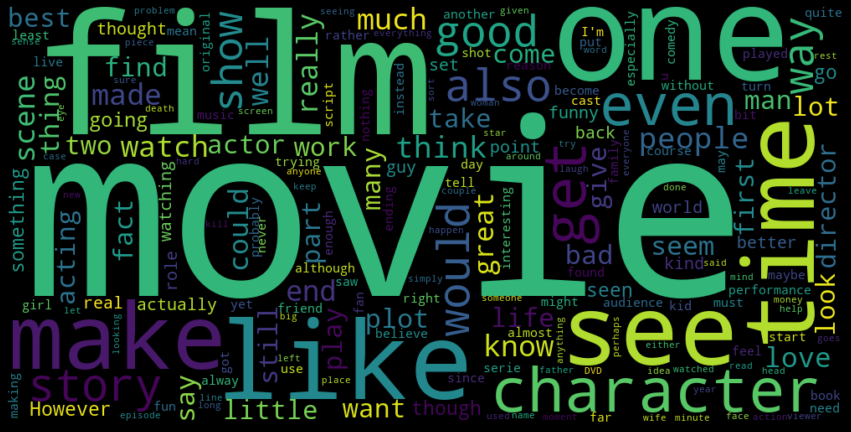

In [134]:
text = " ".join(i for i in train.text)
stop_words = ["br"] + list(stop_words)
wordcloud = WordCloud(stopwords=stop_words, width=1000, height=500).generate(text)
plt.figure(figsize=(15,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

- **Bigrams of most frequent words**

In [135]:
words = train['text'].tolist()

tokenized = [word_tokenize(i) for i in words]
flat_list = [num for sublist in tokenized for num in sublist]

bigram_df = pd.DataFrame(pd.Series(nltk.ngrams(flat_list, 2)).value_counts()).rename_axis('bigram').reset_index('bigram')
bigram_df.columns = ['bigram', 'count']
bigram_df['bigram'] = bigram_df['bigram'].astype("string")
bigram_df.head(10)

,bigram,count
0,"('<', 'br')",161462
1,"('br', '/')",161462
2,"('/', '>')",161462
3,"('>', '<')",80762
4,"('of', 'the')",60065
5,"(',', 'and')",46979
6,"('.', 'The')",42273
7,"('in', 'the')",36798
8,"('.', 'I')",35726
9,"(',', 'but')",33313


- **Peroforming Tokenization**

In [136]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)


X_train = tokenizer.texts_to_sequences(X_train)
X_valid = tokenizer.texts_to_sequences(X_valid)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=120)
X_valid = pad_sequences(X_valid, maxlen=120)
X_test = pad_sequences(X_test, maxlen=120)

In [137]:
size_of_vocabulary = len(tokenizer.word_index)+1
print(size_of_vocabulary)

160302


# **LSTM Model**

In [138]:
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Embedding, Dropout

def LSTM_Model():
  model = tf.keras.Sequential([
      Embedding(size_of_vocabulary, 128, input_length = 120),
      LSTM(15, return_sequences=True),
      Dropout(0.05),
      Dense(1, activation='sigmoid')
  ])
  model.summary()
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

  return model

In [139]:
lstm = LSTM_Model()
lstm_history = lstm.fit(X_train, Y_train, batch_size = 128, epochs = 4,validation_data = (X_valid, Y_valid), verbose = 1)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 120, 128)          20518656  
                                                                 
 lstm_22 (LSTM)              (None, 120, 15)           8640      
                                                                 
 dropout_7 (Dropout)         (None, 120, 15)           0         
                                                                 
 dense_12 (Dense)            (None, 120, 1)            16        
                                                                 
Total params: 20,527,312
Trainable params: 20,527,312
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
313/313 [==============================] - 8s 20ms/step - loss: 0.5386 - accuracy: 0.6982 - val_loss: 0.4964 - val_accuracy: 0.7220
Epoch 2/4
313/313 [============

- **Visaulising the Train Loss**

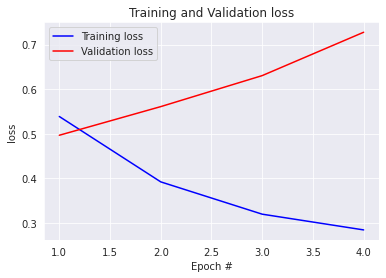

In [140]:
visualise_train(lstm_history)

- **Testing the LSTM model**

In [141]:
lstm_test = lstm.evaluate(X_test, Y_test)

157/157 [==============================] - 1s 5ms/step - loss: 0.6955 - accuracy: 0.7133


## **Bi-Directional RNN Model**

In [142]:
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Embedding, Dropout, Bidirectional

def RNN_Model():
  model = tf.keras.Sequential([
      Embedding(size_of_vocabulary,128,input_length=120),
      Bidirectional(SimpleRNN(20, return_sequences= True,dropout=0.2)),
      Dense(1, activation='sigmoid')
  ])

  model.summary()
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

  return model

In [143]:
rnn = RNN_Model()
rnn_history = rnn.fit(X_train, Y_train, batch_size = 128, epochs = 4, validation_data = (X_valid, Y_valid), verbose = 1)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 120, 128)          20518656  
                                                                 
 bidirectional_4 (Bidirectio  (None, 120, 40)          5960      
 nal)                                                            
                                                                 
 dense_13 (Dense)            (None, 120, 1)            41        
                                                                 
Total params: 20,524,657
Trainable params: 20,524,657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
313/313 [==============================] - 86s 269ms/step - loss: 0.3991 - accuracy: 0.8216 - val_loss: 0.3241 - val_accuracy: 0.8719
Epoch 2/4
313/313 [==============================] - 82s 263ms/step - loss: 0.1812 - accuracy: 

- **Visualising the Train Loss**

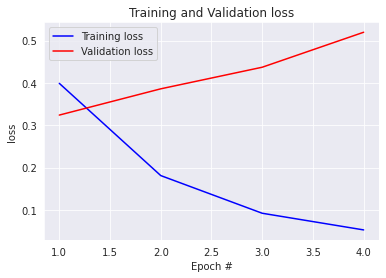

In [144]:
visualise_train(rnn_history)

- **Testing the BiRNN Model**

In [145]:
rnn_test = rnn.evaluate(X_test, Y_test)

157/157 [==============================] - 3s 21ms/step - loss: 0.4998 - accuracy: 0.8660


### **Creating my own dataset for testing**

In [146]:
myTest = pd.read_csv('myData.csv')
myTest.head(10)

,text,label
0,this is a very good movie,1
1,the movie is not that good,0
2,the movie is good but the acting performance i...,1
3,the movie is great,1
4,the movie was horrible,0
5,the movie is so bad it made me feel anxious,0
6,the movie is so good it made me feel happy,1
7,this movie could've been better had the cast p...,0
8,movie good watching enjoyed,1


- **Applying required preprocessing**

In [147]:
X_myTest = myTest['text']
Y_myTest = myTest['label']

X_myTest = X_myTest.apply(lambda x: preprocess(x))
X_myTest = X_myTest.apply(lambda x: WordNetLemmatizer().lemmatize(x))

X_myTest = tokenizer.texts_to_sequences(X_myTest)
X_myTest = pad_sequences(X_myTest, maxlen=120)

- **Testing LSTM Model on my custom dataset**

In [148]:
lstm.evaluate(X_myTest, Y_myTest)

1/1 [==============================] - 0s 20ms/step - loss: 0.6879 - accuracy: 0.5639


[0.6879212856292725, 0.5638888478279114]

- **Testing Bi-RNN Model on my custom dataset**

In [149]:
rnn.evaluate(X_myTest, Y_myTest)

1/1 [==============================] - 0s 37ms/step - loss: 1.4986 - accuracy: 0.6296


[1.4985557794570923, 0.6296296119689941]